# ch04.01 UNet-Image segmentation

* 날짜: 2022.08.01
* 이름: 윤태우

## 학습내용
    - Image segmentation에 대해 이해한다.
    - UNet 모델에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Image Segmentation

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_model.png?raw=true)

## 모델: UNet
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

#### **레포지토리 임포트**

https://github.com/karolzak/keras-unet

```
! git clone https://github.com/karolzak/keras-unet
```


In [1]:
! git clone https://github.com/karolzak/keras-unet

Cloning into 'keras-unet'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1234 (delta 44), reused 75 (delta 34), pack-reused 1136
Receiving objects: 100% (1234/1234), 31.94 MiB | 41.34 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [58]:
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils, callbacks
from keras_unet.models import custom_unet
from PIL import Image

sys.path.append('/content/keras-unet')

#### **모델 생성**

In [ ]:
from keras_unet.models import vanilla_unet

model = vanilla_unet(input_shape = (572, 572, 3))
model.summary()

In [ ]:
utils.plot_model(model, show_shapes = True)

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(512, 512, 3),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid')
utils.plot_model(model, show_shapes = True)

## 데이터셋: Whale-tails
---

### **| 데이터 처리**

#### **데이터 경로 확보**

In [21]:
img_paths = glob.glob('/content/keras-unet/input/whales/*jpg')
mask_paths = glob.glob('/content/keras-unet/input/whales/*png')


print(len(img_paths), img_paths[0])
print(len(mask_paths), mask_paths[0])

500 /content/keras-unet/input/whales/00d641885.jpg
148 /content/keras-unet/input/whales/00e4afee9.png


In [23]:
img_paths = [mask_path.replace('png', 'jpg') for mask_path in mask_paths]
print(len(img_paths), img_paths[0])

148 /content/keras-unet/input/whales/00e4afee9.jpg


#### **넘파이 변환**

In [33]:
from PIL import Image
imgs = []
masks = []
for img_path, mask_path in zip(img_paths, mask_paths) :
  # path to img
  img = Image.open(img_path).resize( (384, 384) )
  img = np.array(img)
  imgs.append(img)
  # path to mask
  mask = Image.open(mask_path).resize( (384, 384) )
  mask = np.array(mask)

  masks.append(mask)

imgs = np.asarray(imgs)
masks = np.asarray(masks)
masks = np.expand_dims(masks, 3)
print(imgs.shape, masks.shape)

(148, 384, 384, 3) (148, 384, 384, 1)


#### **데이터 확인**

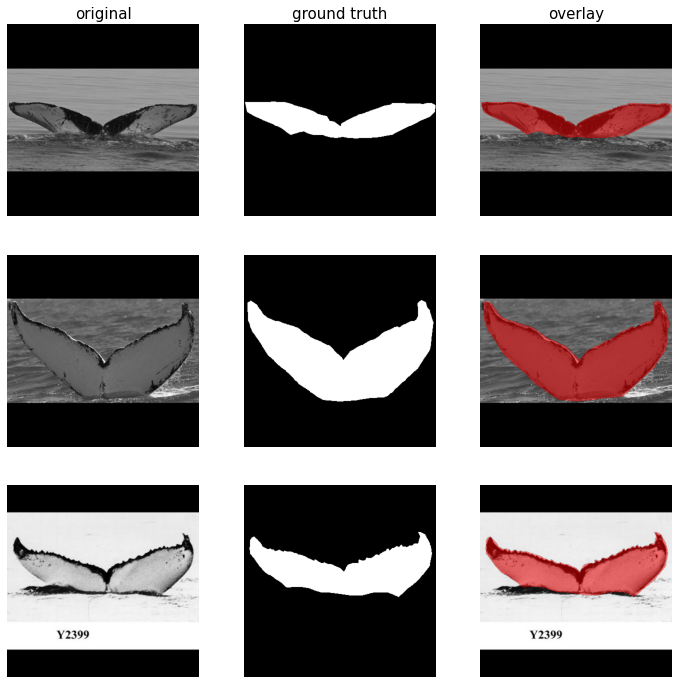

In [29]:
from keras_unet.utils import plot_imgs
plot_imgs(imgs, masks, nm_img_to_plot = 3)

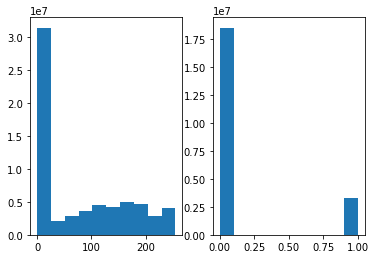

In [34]:
plt.subplot(121);_=plt.hist(imgs.flatten())
plt.subplot(122);_=plt.hist(masks.flatten())

In [44]:
mn, mx = np.min(imgs.flatten()), np.max(imgs.flatten())
print(f'인풋 이미지의 값 범위 : ', mn, mx)
print(f'마스크의 값 범위 : {set(mask.flatten())}')

인풋 이미지의 값 범위 :  0 255
마스크의 값 범위 : {0, 1}


#### **전처리**

In [45]:
def whale_preprocessing(imgs, masks) :
  imgs = imgs/255.0
  return imgs, masks

In [52]:
imgs_ds, masks_ds = whale_preprocessing(imgs, masks)
mn, mx = np.min(imgs_ds.flatten()), np.max(imgs_ds.flatten())
print(f'인풋 이미지의 값 범위 : {mn}, {mx}')
print(f'마스크의 값 범위 : {set(masks_ds.flatten())}')

인풋 이미지의 값 범위 : 0.0, 1.0
마스크의 값 범위 : {0, 1}


In [48]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imgs_ds, masks_ds,
                                                    test_size = 0.1,
                                                    random_state = 0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((133, 384, 384, 3), (15, 384, 384, 3), (133, 384, 384, 1), (15, 384, 384, 1))

#### **이미지 증강**

In [54]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(x_train, y_train,
                          batch_size = 2,
                          data_gen_args = dict(rotation_range = 5.0,
                                               height_shift_range = 0.05,
                                               width_shift_range = 0.05,
                                               shear_range = 40,
                                               horizontal_flip = True,
                                               vertical_flip = False,
                                               fill_mode = 'constant'))

(2, 384, 384, 3) (2, 384, 384, 1)


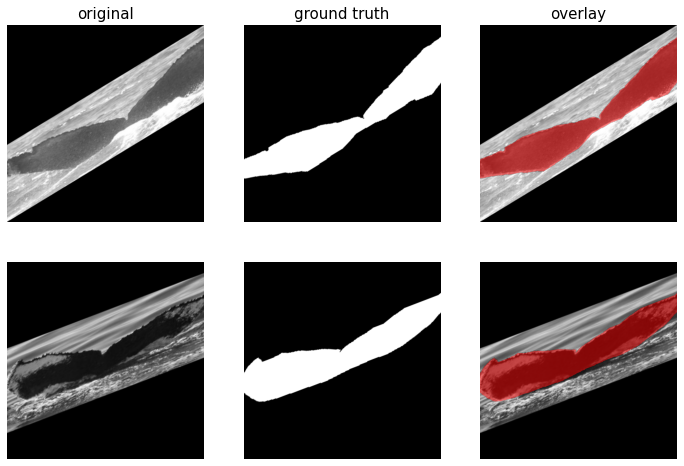

In [55]:
samples = next(train_gen)
xs, ys = samples
print(xs.shape, ys.shape)
plot_imgs(xs,ys,nm_img_to_plot = 2)

### **| 모델 생성 및 학습**

#### **모델 생성**

In [57]:
model = custom_unet((384,384,3), 
                    filters=32, output_activation = 'sigmoid')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 384, 384, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 384, 384, 32  128        ['conv2d_76[0][0]']              
 ormalization)                  )                                                           

#### **컴파일 및 학습**

In [59]:
ckp = callbacks.ModelCheckpoint('unet_whale.h5', 
                                monitor = 'val_loss',
                                save_best_only = True)

In [60]:
from keras_unet.metrics import iou
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = [iou]) # 케라스에서 iou 함수 지원하지 않음

In [62]:
history = model.fit(train_gen,
                    epochs = 50,
                    steps_per_epoch = 200,
                    validation_data = (x_test,y_test),
                    callbacks = [ckp])

Epoch 1/50
200/200 [==============================] - 32s 157ms/step - loss: 0.4238 - iou: 0.2761 - val_loss: 6.3950 - val_iou: 0.2779
Epoch 2/50
200/200 [==============================] - 25s 124ms/step - loss: 0.2341 - iou: 0.4080 - val_loss: 0.7501 - val_iou: 0.3979
Epoch 3/50
200/200 [==============================] - 24s 121ms/step - loss: 0.1879 - iou: 0.4887 - val_loss: 0.3158 - val_iou: 0.5492
Epoch 4/50
200/200 [==============================] - 29s 146ms/step - loss: 0.1613 - iou: 0.5462 - val_loss: 0.1244 - val_iou: 0.6509
Epoch 5/50
200/200 [==============================] - 29s 146ms/step - loss: 0.1420 - iou: 0.5875 - val_loss: 0.1016 - val_iou: 0.7053
Epoch 6/50
200/200 [==============================] - 24s 120ms/step - loss: 0.1364 - iou: 0.6083 - val_loss: 0.1352 - val_iou: 0.7211
Epoch 7/50
200/200 [==============================] - 24s 120ms/step - loss: 0.1197 - iou: 0.6484 - val_loss: 0.1054 - val_iou: 0.6873
Epoch 8/50
200/200 [==============================] - 2

#### **Plot training history**

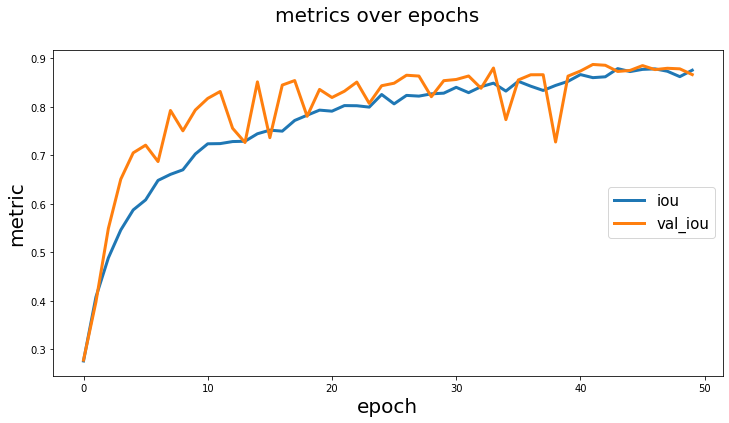

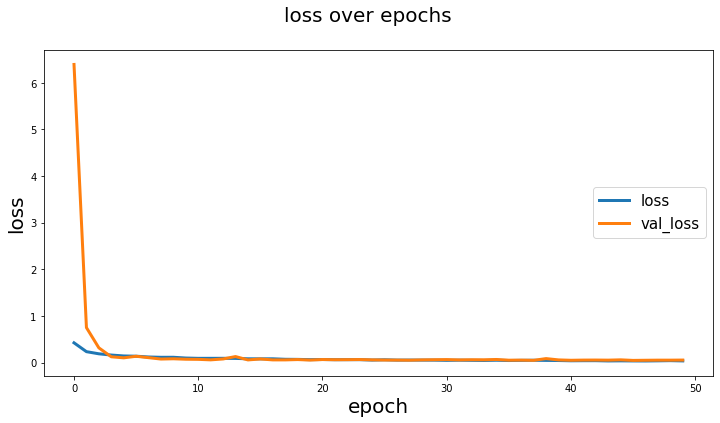

In [64]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history, 
                  metrics = ['iou', 'val_iou'],
                  losses = ['loss', 'val_loss'])

#### **Plot original + ground truth + pred + overlay (pred on top of original)**

In [65]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)

(15, 384, 384, 1) (15, 384, 384, 1)


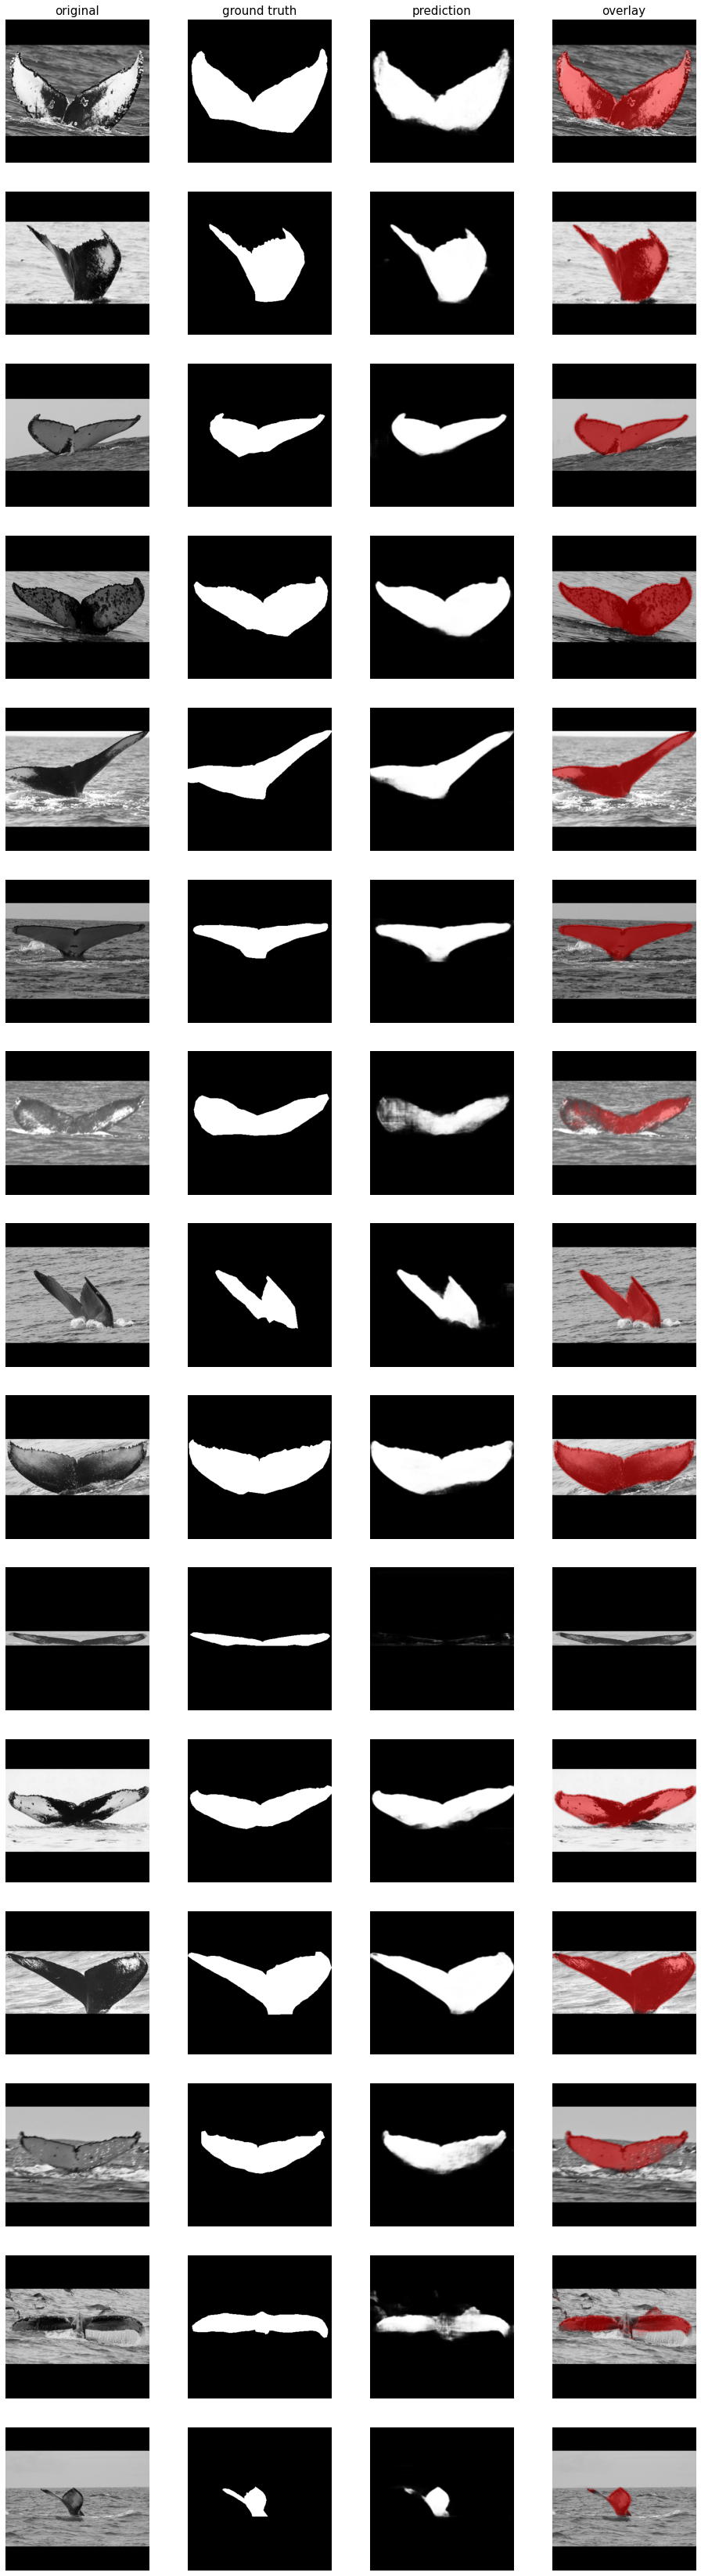

In [66]:
plot_imgs(org_imgs = x_test, 
          mask_imgs = y_test,
          pred_imgs = y_pred,
          nm_img_to_plot = 15)

## 데이터셋: kz-isbi-challenge
---

https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-isbi-challenge.ipynb

In [70]:
# 이미지 크기 확인
a = Image.open('/content/keras-unet/input/isbi2015/train/image/0.png')
a = np.array(a)
a.shape

(512, 512)

In [73]:
img_paths = glob.glob('/content/keras-unet/input/isbi2015/train/image/*png')
label_paths = glob.glob('/content/keras-unet/input/isbi2015/train/label/*png')
from PIL import Image
imgs = []
labels = []
for img_path, label_path in zip(img_paths, label_paths) :
  # path to img
  img = Image.open(img_path).resize( (350, 350) )
  img = np.array(img)
  imgs.append(img)
  # path to mask
  label = Image.open(label_path).resize( (350, 350) )
  label = np.array(label)

  labels.append(label)

imgs = np.asarray(imgs)
imgs = np.expand_dims(imgs, 3)
labels = np.asarray(labels)
labels = np.expand_dims(labels, 3)
print(imgs.shape, labels.shape)

(30, 350, 350, 1) (30, 350, 350, 1)


In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(512, 512, 3),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid')
utils.plot_model(model, show_shapes = True, dpi=50)

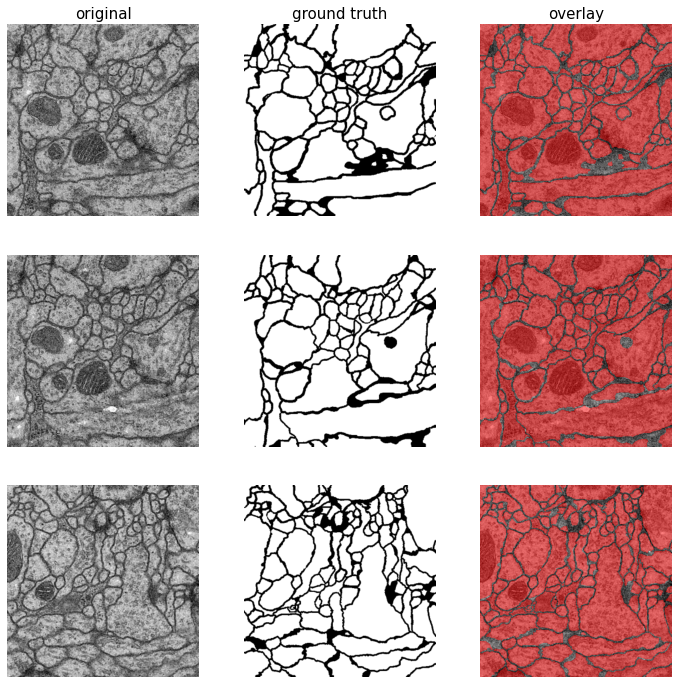

In [79]:
from keras_unet.utils import plot_imgs
plot_imgs(imgs, labels, nm_img_to_plot = 3)

In [83]:
# 전처리 필요한지 확인
mn,mx = np.min(imgs.flatten()), np.max(imgs.flatten())
print('input 이미지 값들의 범위 : ', mn, '~', mx)
mn,mx = np.min(labels.flatten()), np.max(labels.flatten())
print('label 이미지 값들의 범위 : ', mn, '~', mx)

input 이미지 값들의 범위 :  0 ~ 255
label 이미지 값들의 범위 :  0 ~ 255


In [84]:
# input 이미지 전처리
def isbi_preprocessing(imgs, labels) :
  imgs_ds = imgs / 255.0
  return imgs_ds, labels

isbi_preprocessing

In [ ]:


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imgs_ds, label_ds,
                                                    test_size = 0.1,
                                                    random_state = 0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape